---


<h1 style="text-align:center"> 
Lung Cancer Classification using CT Data (Smoke Detector)
</h1><style>

--- 
## Libraries


In [19]:
import pandas as pd
import pylidc as pl
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

In [20]:
#pylidc must be in lung-cancer-classification directory
print(pl.__file__)

/home/inesamorim46/3ano1sem/labiacd/lung-cancer-classification/lung-cancer-classification/pylidc/__init__.py


---

## Importing XML files

In [21]:
plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

In [22]:
#%pip install xlrd

In [23]:
nodule_counts_df = pd.read_excel('lidc-idri-nodule-counts-6-23-2015.xlsx')
nodule_counts_df
#maybe eliminar quarta e quinta coluna

,TCIA Patent ID,Total Number of Nodules*,Number of Nodules >=3mm**,Number of Nodules <3mm***,Unnamed: 4,Unnamed: 5
0,LIDC-IDRI-0001,4,1,3,NaN,NaN
1,LIDC-IDRI-0002,12,1,11,NaN,*total number of lesions that received either ...
2,LIDC-IDRI-0003,4,4,0,NaN,"**total number of lesions that received a ""nod..."
3,LIDC-IDRI-0004,4,1,3,NaN,"***total number of lesions that received a ""no..."
4,LIDC-IDRI-0005,9,3,6,NaN,NaN
...,...,...,...,...,...,...
1014,LIDC-IDRI-1009,2,1,1,NaN,NaN
1015,LIDC-IDRI-1010,10,1,9,NaN,NaN
1016,LIDC-IDRI-1011,4,4,0,NaN,NaN
1017,LIDC-IDRI-1012,1,1,0,NaN,NaN


In [24]:
pacient_data_df = pd.read_excel('tcia-diagnosis-data-2012-04-20.xls')
pacient_data_df 
#nem todos os pacientes têm historial registado (157 em 1010)

,TCIA Patient ID,"Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n",Diagnosis Method\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response,Primary tumor site for metastatic disease,"Nodule 1\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 1\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 2\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 2\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 3\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 3\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 4\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 4\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 5\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 5\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LIDC-IDRI-0088,3,0,Uterine Cancer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LIDC-IDRI-0090,2,3,NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LIDC-IDRI-0994,2,3,LUL Large cell CA,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,LIDC-IDRI-1002,2,2,non-small cell carcinoma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,LIDC-IDRI-1004,2,3,LUL NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,LIDC-IDRI-1010,0,0,lymphoma,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---


## Importing Annotations

In [25]:
annotation = pl.query(pl.Annotation).first()
print(annotation.scan.patient_id)

LIDC-IDRI-0078


In [26]:
pid = 'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
print(len(scan.annotations))

4


In [27]:
nods = scan.cluster_annotations()

<frozen _collections_abc>:780: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
/home/inesamorim46/3ano1sem/labiacd/lung-cancer-classification/lung-cancer-classification/pylidc/Annotation.py:764: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  facecolors=plt.cm.cmap_d[cmap](t))
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamor

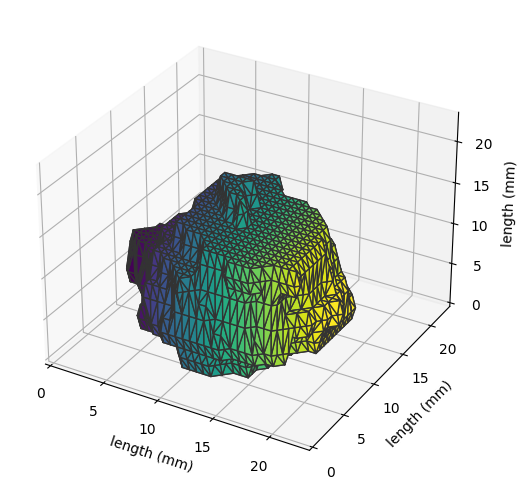

In [28]:
annotation.visualize_in_3d()

### Visualization of the annotated nodule

In [15]:
volume = annotation.scan.to_volume()
padding = [(30,10), (10,25), (0,0)]

mask = annotation.boolean_mask(pad=padding)
bbox = annotation.bbox(pad=padding)

fig,ax = plt.subplots(1,2,figsize=(5,3))

ax[0].imshow(vol[bbox][:,:,2], cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].imshow(mask[:,:,2], cmap=plt.cm.gray)
ax[1].axis('off')

plt.tight_layout()
plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
plt.show()

Loading dicom files ... This may take a moment.


/home/inesamorim46/3ano1sem/labiacd/lung-cancer-classification/lung-cancer-classification/pylidc/Scan.py:71: UserWarning: Could not find `dicom` configuration section or  `path` configuration option under that section.A template config file will be written to /home/inesamorim46/.pylidcrc.
  warnings.warn(msg.format(conf_file))


RuntimeError: Could not establish path to dicom files. Have you specified the `path` option in the configuration file /home/inesamorim46/.pylidcrc?

### Surface Visualization

In [ ]:

# Verifica os colormaps disponíveis
print(plt.colormaps())

# Carregar a anotação de lobulação 5
ann = pl.query(pl.Annotation)\
        .filter(pl.Annotation.lobulation == 5).first()

# Usar a função visualize_in_3d com colormap válido
ann.visualize_in_3d(cmap='viridis') 

---

In [4]:
path_to_annotations = 'LIDC-XML-only'

In [6]:
path = 'C:/Users/Daniela/Desktop/Fac/3ºano/Lab_IACD/Project1/manifest-1727162347556/LIDC-IDRI'
f = open('C:/Users/Daniela/pylidc.conf', 'w')
f.write(f'[dicom]\npath = {path}\n\n')
f.close()

In [3]:
pid = 'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

In [ ]:
vol = scan.to_volume()
print(vol.shape) # (dim, dim, depth)

plt.figure(figsize=(5, 5))
plt.imshow(vol[:,:,0])
plt.show() # show the first-level slice

In [ ]:
#extract information from an XML file
def parse_xml(file):
    tree = ET.parse(file)
    root = tree.getroot()

    data = []
    for nodule in root